In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 

transfer learning and train inceptionv3 model on case 1: Real images only

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.optimizers import Adam

base_dir = 'C:/brain_tumor/version2/notebook/Training'
class_names = ['glioma', 'meningioma', 'pituitary']

X = []
y = []

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

X = X.astype('float32') / 255.0

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) 
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

X_final, X_val, y_final, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_final, y_final,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=4
)

In [ ]:
model.save('inception_case_1.h5')

In [ ]:
# plot accuracy and loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

transfer learning and train inceptionv3 model on case 2: Real images and data augmentation methods

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.optimizers import Adam

base_dir = 'C:/brain_tumor/version2/notebook/Training'
class_names = ['glioma', 'meningioma', 'pituitary']

X = []
y = []

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

X = X.astype('float32') / 255.0

# Data augmentation setup
datagen = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.2, zoom_range=0.2)

# Generate 200 augmented images for each class
X_augmented = []
y_augmented = []
for class_name in class_names:
    class_idx = class_names.index(class_name)
    class_images = X[y == class_idx]
    class_labels = y[y == class_idx]
    
    augmented_images = datagen.flow(class_images, class_labels, batch_size=1, shuffle=False)
    
    for _ in range(200):
        aug_img, aug_label = augmented_images.next()
        X_augmented.append(aug_img[0])
        y_augmented.append(aug_label[0])

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

X_combined = np.concatenate((X, X_augmented), axis=0)
y_combined = np.concatenate((y, y_augmented), axis=0)

X_final2, X_val2, y_final2, y_val2 = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x) 
predictions = Dense(len(class_names), activation='softmax')(x)

model2 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model2.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(
    X_final2, y_final2,
    epochs=100,
    validation_data=(X_val2, y_val2),
    batch_size=4
)

In [ ]:
model2.save('inception_case_2.h5')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


transfer learning and train inceptionv3 model on case 3: Real images and generated images

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.optimizers import Adam
from keras.regularizers import l2

base_dir = 'C:/brain_tumor/version2/notebook/Training'
gen_dir = 'C:/brain_tumor/version2/notebook/generated_dataset'
class_names = ['glioma', 'meningioma', 'pituitary']

X = []
y = []
X_generated = []
y_generated = []

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    gen_class_dir = os.path.join(gen_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        X.append(img)
        y.append(label)
    for image_name in os.listdir(gen_class_dir):
        image_path = os.path.join(gen_class_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (128, 128))
        X_generated.append(image)
        y_generated.append(label)

X = np.array(X)
y = np.array(y)
X_generated = np.array(X_generated)
y_generated = np.array(y_generated)

X = X.astype('float32') / 255.0
X_generated = X_generated.astype('float32') / 255.0

X_train_combined = np.concatenate((X, X_generated), axis=0)
y_train_combined = np.concatenate((y, y_generated), axis=0)

shuffle_indices = np.random.permutation(len(X_train_combined))
X_train_combined_shuffled = X_train_combined[shuffle_indices]
y_train_combined_shuffled = y_train_combined[shuffle_indices]

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.7)(x)  
predictions = Dense(len(class_names), activation='softmax')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

X_final1, X_val1, y_final1, y_val1 = train_test_split(X_train_combined_shuffled, y_train_combined_shuffled, test_size=0.2, random_state=42)

model1.compile(optimizer=Adam(learning_rate=0.0002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(
    X_final1, y_final1,
    epochs=100,
    validation_data=(X_val1, y_val1),
    batch_size=4
)

In [ ]:
model1.save('inception_case_3.h5')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Below code blocks are just my testing process

In [2]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.optimizers import Adam

# base_dir = 'C:/brain_tumor/version2/notebook/classify_dataset'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)

# X = np.array(X)
# y = np.array(y)

# X = X.astype('float32') / 255.0

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_train])
# X_test = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_test])

# base_model = InceptionV3(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)  # Reduce overfitting
# predictions = Dense(len(class_names), activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# X_final, X_val, y_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# model.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history = model.fit(
#     X_final, y_final,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     batch_size=4
# )

# test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=4)
# print(f"Test accuracy for Case-3a: {test_acc}")

# # Save the trained model
# # model.save("case_3a_trained_model.h5")


Epoch 1/100
461/461 [==============================] - 19s 32ms/step - loss: 0.8442 - accuracy: 0.6229 - val_loss: 0.7014 - val_accuracy: 0.6876
Epoch 2/100
461/461 [==============================] - 13s 28ms/step - loss: 0.7055 - accuracy: 0.6961 - val_loss: 0.6348 - val_accuracy: 0.7419
Epoch 3/100
461/461 [==============================] - 14s 30ms/step - loss: 0.6650 - accuracy: 0.7162 - val_loss: 0.6049 - val_accuracy: 0.7462
Epoch 4/100
461/461 [==============================] - 14s 30ms/step - loss: 0.6134 - accuracy: 0.7450 - val_loss: 0.5748 - val_accuracy: 0.7636
Epoch 5/100
461/461 [==============================] - 14s 29ms/step - loss: 0.5816 - accuracy: 0.7558 - val_loss: 0.5452 - val_accuracy: 0.7896
Epoch 6/100
461/461 [==============================] - 14s 30ms/step - loss: 0.5596 - accuracy: 0.7640 - val_loss: 0.5673 - val_accuracy: 0.7809
Epoch 7/100
461/461 [==============================] - 14s 29ms/step - loss: 0.5440 - accuracy: 0.7727 - val_loss: 0.5083 - val_ac

In [4]:
# model.save("100e_inception(case3a).h5")

In [5]:
# from keras.models import load_model

# loaded_model = load_model("100e_inception(case3a).h5")

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()


18/18 [==============================] - 2s 33ms/step


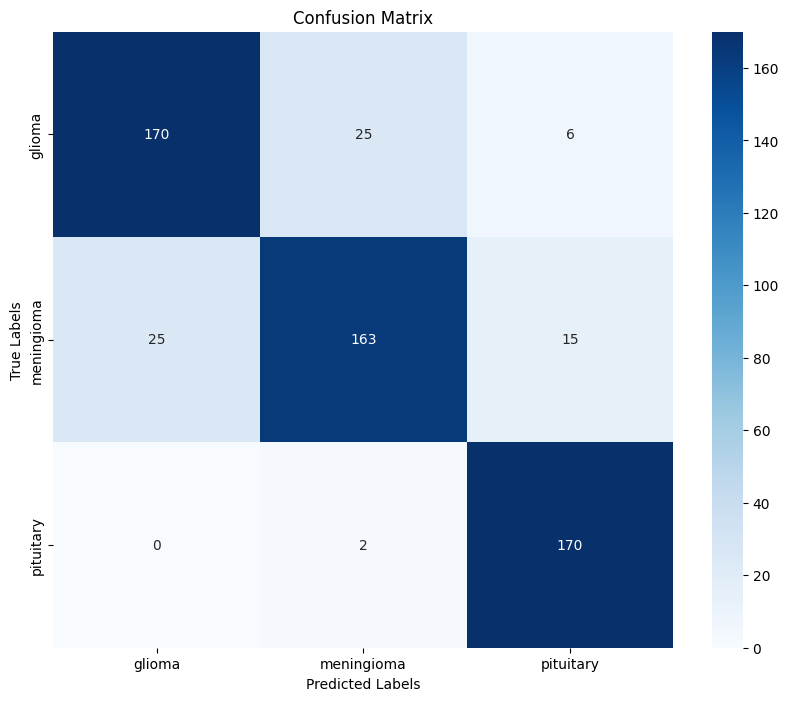

In [7]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# y_pred = loaded_model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


In [2]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.optimizers import Adam
# from keras.regularizers import l2

# base_dir = 'C:/brain_tumor/version2/notebook/classify_dataset'
# gen_dir = 'C:/brain_tumor/version2/notebook/generated_dataset'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []
# X_generated = []
# y_generated = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     gen_class_dir = os.path.join(gen_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)
#     for image_name in os.listdir(gen_class_dir):
#         image_path = os.path.join(gen_class_dir, image_name)
#         image = cv2.imread(image_path)
#         image = cv2.resize(image, (128, 128))
#         X_generated.append(image)
#         y_generated.append(label)

# X = np.array(X)
# y = np.array(y)
# X_generated = np.array(X_generated)
# y_generated = np.array(y_generated)

# X = X.astype('float32') / 255.0
# X_generated = X_generated.astype('float32') / 255.0

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# X_train = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_train])
# X_test = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_test])
# X_generated = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_generated])

# X_train_combined = np.concatenate((X_train, X_generated), axis=0)
# y_train_combined = np.concatenate((y_train, y_generated), axis=0)

# shuffle_indices = np.random.permutation(len(X_train_combined))
# X_train_combined_shuffled = X_train_combined[shuffle_indices]
# y_train_combined_shuffled = y_train_combined[shuffle_indices]

# base_model = InceptionV3(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.7)(x)  
# predictions = Dense(len(class_names), activation='softmax')(x)

# model1 = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# X_final1, X_val1, y_final1, y_val1 = train_test_split(X_train_combined_shuffled, y_train_combined_shuffled, test_size=0.2, random_state=42)

# model1.compile(optimizer=Adam(learning_rate=0.0002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history1 = model1.fit(
#     X_final1, y_final1,
#     epochs=100,
#     validation_data=(X_val1, y_val1),
#     batch_size=4
# )

# test_loss1, test_acc1 = model1.evaluate(X_test, y_test)
# print(f"Test accuracy for Case-3b: {test_acc1}")


Epoch 1/100
639/639 [==============================] - 32s 30ms/step - loss: 1.0507 - accuracy: 0.6071 - val_loss: 0.8958 - val_accuracy: 0.6870
Epoch 2/100
639/639 [==============================] - 18s 28ms/step - loss: 0.8835 - accuracy: 0.6745 - val_loss: 0.7692 - val_accuracy: 0.7543
Epoch 3/100
639/639 [==============================] - 18s 27ms/step - loss: 0.8208 - accuracy: 0.7184 - val_loss: 0.7174 - val_accuracy: 0.7668
Epoch 4/100
639/639 [==============================] - 17s 27ms/step - loss: 0.7819 - accuracy: 0.7148 - val_loss: 0.7118 - val_accuracy: 0.7950
Epoch 5/100
639/639 [==============================] - 18s 28ms/step - loss: 0.7473 - accuracy: 0.7242 - val_loss: 0.6646 - val_accuracy: 0.7825
Epoch 6/100
639/639 [==============================] - 19s 29ms/step - loss: 0.7238 - accuracy: 0.7250 - val_loss: 0.6577 - val_accuracy: 0.7950
Epoch 7/100
639/639 [==============================] - 18s 28ms/step - loss: 0.7019 - accuracy: 0.7493 - val_loss: 0.6274 - val_ac

In [3]:
# model1.save('100e_inception(case3b_81_acc).h5')

In [8]:
# from keras.models import load_model

# loaded_model1 = load_model("100e_inception(case3b_81_acc).h5")

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history1.history['loss'])
# plt.plot(history1.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history1.history['accuracy'])
# plt.plot(history1.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [ ]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.optimizers import Adam

# base_dir = 'C:/brain_tumor/version2/notebook/classify_dataset'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)

# X = np.array(X)
# y = np.array(y)

# X = X.astype('float32') / 255.0

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Data augmentation setup
# datagen = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.2, zoom_range=0.2)

# # Generate 200 augmented images for each class
# X_augmented = []
# y_augmented = []
# for class_name in class_names:
#     class_idx = class_names.index(class_name)
#     class_images = X_train[y_train == class_idx]
#     class_labels = y_train[y_train == class_idx]
    
#     augmented_images = datagen.flow(class_images, class_labels, batch_size=1, shuffle=False)
    
#     for _ in range(200):
#         aug_img, aug_label = augmented_images.next()
#         X_augmented.append(aug_img[0])
#         y_augmented.append(aug_label[0])

# X_augmented = np.array(X_augmented)
# y_augmented = np.array(y_augmented)

# X_combined = np.concatenate((X_train, X_augmented), axis=0)
# y_combined = np.concatenate((y_train, y_augmented), axis=0)

# X_final2, X_val2, y_final2, y_val2 = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# base_model = InceptionV3(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.6)(x) 
# predictions = Dense(len(class_names), activation='softmax')(x)

# model2 = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# model2.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history2 = model2.fit(
#     X_final2, y_final2,
#     epochs=100,
#     validation_data=(X_val2, y_val2),
#     batch_size=4
# )

# test_loss2, test_acc2 = model2.evaluate(X_test, y_test)
# print(f"Test accuracy for Case-3a: {test_acc2}")


In [ ]:
# model2.save("100e_inception(case3c).h5")

In [ ]:
# from keras.models import load_model

# loaded_model2 = load_model("100e_inception(case3c).h5")

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history2.history['loss'])
# plt.plot(history2.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history2.history['accuracy'])
# plt.plot(history2.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# y_pred = loaded_model2.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [2]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.optimizers import Adam
# from keras.regularizers import l2

# base_dir = 'C:/brain_tumor/version2/notebook/classify_dataset'
# gen_dir = 'C:/brain_tumor/version2/notebook/generated_dataset_1'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []
# X_generated = []
# y_generated = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     gen_class_dir = os.path.join(gen_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)
#     for image_name in os.listdir(gen_class_dir):
#         image_path = os.path.join(gen_class_dir, image_name)
#         image = cv2.imread(image_path)
#         image = cv2.resize(image, (128, 128))
#         X_generated.append(image)
#         y_generated.append(label)

# X = np.array(X)
# y = np.array(y)
# X_generated = np.array(X_generated)
# y_generated = np.array(y_generated)

# X = X.astype('float32') / 255.0
# X_generated = X_generated.astype('float32') / 255.0

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# X_train = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_train])
# X_test = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_test])
# X_generated = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_generated])

# X_train_combined = np.concatenate((X_train, X_generated), axis=0)
# y_train_combined = np.concatenate((y_train, y_generated), axis=0)

# shuffle_indices = np.random.permutation(len(X_train_combined))
# X_train_combined_shuffled = X_train_combined[shuffle_indices]
# y_train_combined_shuffled = y_train_combined[shuffle_indices]

# base_model = InceptionV3(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.7)(x)  
# predictions = Dense(len(class_names), activation='softmax')(x)

# model1 = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# X_final1, X_val1, y_final1, y_val1 = train_test_split(X_train_combined_shuffled, y_train_combined_shuffled, test_size=0.2, random_state=42)

# model1.compile(optimizer=Adam(learning_rate=0.0002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history1 = model1.fit(
#     X_final1, y_final1,
#     epochs=100,
#     validation_data=(X_val1, y_val1),
#     batch_size=4
# )

# test_loss1, test_acc1 = model1.evaluate(X_test, y_test)
# print(f"Test accuracy for Case-3b: {test_acc1}")


Epoch 1/100
639/639 [==============================] - 28s 29ms/step - loss: 1.0714 - accuracy: 0.5856 - val_loss: 0.8372 - val_accuracy: 0.7246
Epoch 2/100
639/639 [==============================] - 18s 28ms/step - loss: 0.8899 - accuracy: 0.6780 - val_loss: 0.7828 - val_accuracy: 0.7512
Epoch 3/100
639/639 [==============================] - 19s 30ms/step - loss: 0.8318 - accuracy: 0.6937 - val_loss: 0.7585 - val_accuracy: 0.7512
Epoch 4/100
639/639 [==============================] - 20s 31ms/step - loss: 0.7958 - accuracy: 0.7109 - val_loss: 0.6859 - val_accuracy: 0.7700
Epoch 5/100
639/639 [==============================] - 20s 31ms/step - loss: 0.7589 - accuracy: 0.7231 - val_loss: 0.6768 - val_accuracy: 0.7621
Epoch 6/100
639/639 [==============================] - 19s 30ms/step - loss: 0.7336 - accuracy: 0.7329 - val_loss: 0.6597 - val_accuracy: 0.7590
Epoch 7/100
639/639 [==============================] - 19s 30ms/step - loss: 0.7066 - accuracy: 0.7333 - val_loss: 0.6401 - val_ac

In [3]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.optimizers import Adam

# base_dir = 'C:/brain_tumor/version2/notebook/Training'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)

# X = np.array(X)
# y = np.array(y)

# X = X.astype('float32') / 255.0

# base_model = InceptionV3(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x) 
# predictions = Dense(len(class_names), activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# X_final, X_val, y_final, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# model.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history = model.fit(
#     X_final, y_final,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     batch_size=4
# )

Epoch 1/100
824/824 [==============================] - 32s 29ms/step - loss: 0.7687 - accuracy: 0.6863 - val_loss: 0.5113 - val_accuracy: 0.7718
Epoch 2/100
824/824 [==============================] - 22s 27ms/step - loss: 0.5044 - accuracy: 0.7944 - val_loss: 0.4362 - val_accuracy: 0.7949
Epoch 3/100
824/824 [==============================] - 23s 28ms/step - loss: 0.4402 - accuracy: 0.8184 - val_loss: 0.4154 - val_accuracy: 0.8374
Epoch 4/100
824/824 [==============================] - 23s 28ms/step - loss: 0.3870 - accuracy: 0.8418 - val_loss: 0.3974 - val_accuracy: 0.8386
Epoch 5/100
824/824 [==============================] - 24s 29ms/step - loss: 0.3530 - accuracy: 0.8551 - val_loss: 0.3722 - val_accuracy: 0.8434
Epoch 6/100
824/824 [==============================] - 24s 29ms/step - loss: 0.3276 - accuracy: 0.8740 - val_loss: 0.3540 - val_accuracy: 0.8495
Epoch 7/100
824/824 [==============================] - 25s 30ms/step - loss: 0.3074 - accuracy: 0.8776 - val_loss: 0.3584 - val_ac

In [4]:
# model.save('inception_case_1.h5')

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [ ]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.optimizers import Adam

# base_dir = 'C:/brain_tumor/version2/notebook/Training'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)

# X = np.array(X)
# y = np.array(y)

# X = X.astype('float32') / 255.0

# # Data augmentation setup
# datagen = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.2, zoom_range=0.2)

# # Generate 200 augmented images for each class
# X_augmented = []
# y_augmented = []
# for class_name in class_names:
#     class_idx = class_names.index(class_name)
#     class_images = X_train[y_train == class_idx]
#     class_labels = y_train[y_train == class_idx]
    
#     augmented_images = datagen.flow(class_images, class_labels, batch_size=1, shuffle=False)
    
#     for _ in range(200):
#         aug_img, aug_label = augmented_images.next()
#         X_augmented.append(aug_img[0])
#         y_augmented.append(aug_label[0])

# X_augmented = np.array(X_augmented)
# y_augmented = np.array(y_augmented)

# X_combined = np.concatenate((X_train, X_augmented), axis=0)
# y_combined = np.concatenate((y_train, y_augmented), axis=0)

# X_final2, X_val2, y_final2, y_val2 = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# base_model = InceptionV3(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.6)(x) 
# predictions = Dense(len(class_names), activation='softmax')(x)

# model2 = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# model2.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history2 = model2.fit(
#     X_final2, y_final2,
#     epochs=100,
#     validation_data=(X_val2, y_val2),
#     batch_size=4
# )

In [ ]:
# model2.save('inception_case_2.h5')

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history2.history['loss'])
# plt.plot(history2.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history2.history['accuracy'])
# plt.plot(history2.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()


In [ ]:
# import os
# import cv2
# import numpy as np
# from sklearn.model_selection import train_test_split
# from keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras.optimizers import Adam
# from keras.regularizers import l2

# base_dir = 'C:/brain_tumor/version2/notebook/Training'
# gen_dir = 'C:/brain_tumor/version2/notebook/generated_dataset'
# class_names = ['glioma', 'meningioma', 'pituitary']

# X = []
# y = []
# X_generated = []
# y_generated = []

# for label, class_name in enumerate(class_names):
#     class_dir = os.path.join(base_dir, class_name)
#     gen_class_dir = os.path.join(gen_dir, class_name)
#     for img_name in os.listdir(class_dir):
#         img_path = os.path.join(class_dir, img_name)
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (128, 128))
#         X.append(img)
#         y.append(label)
#     for image_name in os.listdir(gen_class_dir):
#         image_path = os.path.join(gen_class_dir, image_name)
#         image = cv2.imread(image_path)
#         image = cv2.resize(image, (128, 128))
#         X_generated.append(image)
#         y_generated.append(label)

# X = np.array(X)
# y = np.array(y)
# X_generated = np.array(X_generated)
# y_generated = np.array(y_generated)

# X = X.astype('float32') / 255.0
# X_generated = X_generated.astype('float32') / 255.0

# X_train = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_train])
# X_test = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_test])
# X_generated = np.array([preprocess_input(cv2.resize(img, (128, 128))) for img in X_generated])

# X_train_combined = np.concatenate((X_train, X_generated), axis=0)
# y_train_combined = np.concatenate((y_train, y_generated), axis=0)

# shuffle_indices = np.random.permutation(len(X_train_combined))
# X_train_combined_shuffled = X_train_combined[shuffle_indices]
# y_train_combined_shuffled = y_train_combined[shuffle_indices]

# base_model = InceptionV3(weights='imagenet', include_top=False)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.7)(x)  
# predictions = Dense(len(class_names), activation='softmax')(x)

# model1 = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# X_final1, X_val1, y_final1, y_val1 = train_test_split(X_train_combined_shuffled, y_train_combined_shuffled, test_size=0.2, random_state=42)

# model1.compile(optimizer=Adam(learning_rate=0.0002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# history1 = model1.fit(
#     X_final1, y_final1,
#     epochs=100,
#     validation_data=(X_val1, y_val1),
#     batch_size=4
# )

In [ ]:
# model.save('inception_case_3.h5')

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history1.history['loss'])
# plt.plot(history1.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(history1.history['accuracy'])
# plt.plot(history1.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
